In [182]:
import os
import sys
import argparse
import datetime
import xarray as xr
import pyresample as pr
import numpy as np
from netCDF4 import Dataset

from pyproj import Transformer
from warnings import filterwarnings
filterwarnings('ignore')

In [183]:
def seconds_to_unix_time(seconds_since_1978):
    """Convert seconds since 1978-01-01 to Unix timestamp."""
    base_datetime = datetime.datetime(1978, 1, 1, 0, 0, 0)
    target_datetime = base_datetime + datetime.timedelta(seconds=seconds_since_1978)
    return target_datetime.timestamp()


In [184]:
import numpy as np  
import xarray as xr

def normalize_domain(lat_min, lat_max, lon_min, lon_max):  
    # Step 1: Ensure latitude bounds are valid  
    lat_min = np.clip(lat_min, 0, 90)  
    lat_max = np.clip(lat_max, 0, 90)  

    # Step 2: Normalize longitude values to -180 to 180 range  
    def normalize_longitude(lon):  
        lon = lon % 360  
        if lon > 180:  
            lon -= 360  
        return lon  

    lon_min = normalize_longitude(lon_min)  
    lon_max = normalize_longitude(lon_max)  

    # Step 3: Handle crossing the -180/180 boundary  
    if lon_min > lon_max:  
        # Domain crosses the dateline  
        return {  
            'lat_min': min(lat_min, lat_max),  
            'lat_max': max(lat_min, lat_max),  
            'lon_ranges': [  
                (-180, lon_max),  
                (lon_min, 180)  
            ]  
        }  
    else:  
        # Normal case  
        return {  
            'lat_min': min(lat_min, lat_max),  
            'lat_max': max(lat_min, lat_max),  
            'lon_ranges': [(lon_min, lon_max)]  
        }  

# Example usage  
def select_domain(global_data, domain_info):  
    """  
    global_data: Your grid data  
    domain_info: Output from normalize_domain  
    """  
    
    lat_mask = (global_data['lat'].values >= domain_info['lat_min']) & (global_data['lat'].values <= domain_info['lat_max'])  

    lon_mask = np.zeros_like(global_data['lon'].values, dtype=bool)  
    for lon_range in domain_info['lon_ranges']:  
        lon_mask |= (global_data['lon'].values >= lon_range[0]) & (global_data['lon'].values <= lon_range[1])  

    return lat_mask & lon_mask  


# Your example  
#domain = normalize_domain(55.9, 86.0, -109.7, 37.7)  
#print(domain)  
#print("--------------")
# Test crossing dateline  
#print("Normalized domain")
#crossing_domain = normalize_domain(55.9, 86.0, 170, -170)  
#print(crossing_domain)  

#input_file = "../../sample_data/Cryo_clim/reg_ll_prob_snow_c_date.nc"
#nc = xr.open_dataset(input_file)
#mask = select_domain(nc, crossing_domain)
#print(mask)


In [207]:
def get_geom_def(
    input_file, output_file, harmonie_file, obs_var="prob_snow_c", var_out="prob_snow_c", model_var="fscov", prob_snow_thr=80.0
):
    # Open input datasets
    nc = xr.open_dataset(input_file)
    #nc = nc.assign_coords(lon=((nc.lon + 360) % 360))
    #nc = nc.assign_coords(x=((nc.x + 360) % 360))
    #nc = nc.sortby('x')

    ds_harm = xr.open_dataset(harmonie_file)
    #ds_harm.assign_coords(longitude=((ds_harm.longitude + 360) % 360))
    #ds_harm = ds_harm.sortby('longitude')

    # Create source definition (HARMONIE grid)
    harm_lat = ds_harm["latitude"].values
    harm_lon = ds_harm["longitude"].values
    #print(harm_lon)
    #harm_lon = (harm_lon + 360)%360
    #print("After converting")
    #print(harm_lon)
    
    harm_lon, harm_lat = np.meshgrid(harm_lon, harm_lat)
    #src_def = pr.geometry.GridDefinition(lons=harm_lon, lats=harm_lat)
    src_def = pr.geometry.SwathDefinition(lons=harm_lon, lats=harm_lat)

    # Get the domain bounds from HARMONIE
    lat_min = harm_lat.min()
    lat_max = harm_lat.max()
    lon_min = harm_lon.min()
    lon_max = harm_lon.max()
    
    print("Borders of the harmonie grid")
    print(lat_min,lat_max)
    print(lon_min,lon_max)

    # before using the lon min and max, convert to 0 to 360
    #lon_min, lon_max = (lon_min + 360) % 360, lon_max
    #print("New lon min and max")
    #print(lon_min,lon_max)

    
    # Create target definition (subset of NetCDF grid)
    # Get the 2D lat/lon arrays from the NetCDF file
    nc_lat = nc.lat.values  # This is already 2D
    nc_lon = nc.lon.values  # This is already 2D

    #corrected_lons = (((nc.lon.values + 180) % 360) - 180)  #((nc.lon.values + 180) % 360) - 180)
    #print("Original lons")
    #print(nc_lon)
    #print("Corrected lons")
    #print(corrected_lons)
    #filter undefined values
    nc_lat_filt = nc.lat.where((nc.lat >= 0) & (nc.lat <= 90))
    nc_lon_filt = nc.lon.where((nc.lon >= -180) & (nc.lon <= 180))

    #nc_lon = corrected_lons
    orig_def = pr.geometry.GridDefinition(lons = nc_lon, lats = nc_lat)
    

    # Create mask for points within HARMONIE domain
    domain_mask = (nc_lat >= lat_min) & (nc_lat <= lat_max) & \
                  (nc_lon >= lon_min) & (nc_lon <= lon_max)

    #this one considers only the lat min and max to avoid issues with
    # the lon min and max
    domain_mask = (nc_lat >= lat_min) & (nc_lat <= lat_max) 

    
    #domain = normalize_domain(nc.lat.min().values.item(),nc.lat.max().values.item(),nc.lon.min().values.item(),nc.lon.max().values.item()) 
    domain_normalized = normalize_domain(lat_min,lat_max,lon_min,lon_max)
    extra_mask = select_domain(nc,domain_normalized)
    #domain_mask = extra_mask
    print(domain_normalized) #["lon_ranges"])
    print(domain_mask)
    print(extra_mask)
    #crossing_domain = normalize_domain(lat_min,
    #domain_mask = select_domain(nc,domain)
    # Get the corresponding x and y indices where the mask is True
    y_indices, x_indices = np.where(domain_mask)

    # Get the unique x and y coordinates that fall within our domain
    unique_x = np.unique(nc.x.values[x_indices])
    unique_y = np.unique(nc.y.values[y_indices])

    # Create the target grid definition using the masked coordinates
    x_grid, y_grid = np.meshgrid(unique_x, unique_y)

    # Get corresponding lat/lon for these points
    target_lat = nc_lat[np.ix_(range(len(unique_y)), range(len(unique_x)))]
    target_lon = nc_lon[np.ix_(range(len(unique_y)), range(len(unique_x)))]
    #print(unique_x)
    #print(unique_x.shape)

    #print(type(target_lat))
    #print(type(harm_lat))

    # Create transformer from LAEA to WGS84
    #transformer = Transformer.from_proj(
    #"+proj=laea +ellps=WGS84 +lat_0=90 +lon_0=0",  # Source projection from file
    #"+proj=longlat +ellps=WGS84 +datum=WGS84",     # Target projection (regular lat-lon)
    #always_xy=True
    #)

    # Get the source x and y coordinates
    # Get the source x and y coordinates (already 2D)
    #X = nc.xc.values
    #Y = nc.yc.values

    # Transform source grid coordinates to lat/lon
    #source_lons, source_lats = transformer.transform(X, Y)

    # Create the target grid definition using the masked coordinates
    #x_grid, y_grid = np.meshgrid(source_lons,source_lats)

   
    # Create target definition
    target_def = pr.geometry.GridDefinition(lons=target_lon, lats=target_lat)
    #target_def = pr.geometry.GridDefinition(lons=x_grid, lats=y_grid)
    # Get the arrays
    lons = target_def.lons.copy()  # Make a copy to avoid modifying the original
    lats = target_def.lats.copy()

    # Define the threshold value
    threshold = 1e36

    # Replace values greater than threshold with NaN
    lons[lons > threshold] = np.nan
    lats[lats > threshold] = np.nan

    #     Create a new GridDefinition with the modified arrays
    from pyresample import geometry
    new_grid = geometry.GridDefinition(lons=lons, lats=lats)
    #print(f"lat and lon dimensions")
    #print(target_lat.shape)    
    #print(target_lon.shape)
    print("Borders of the resulting mesh")
    print(unique_y.min(),unique_y.max())
    print(unique_x.min(),unique_x.max())
    #corrected_lons = (((unique_x + 180) % 360) - 180)
    #print(corrected_lons)
    flip_y = np.flip(unique_y) #for some reason this is inverted!!
    return src_def, target_def, orig_def, flip_y, unique_x


In [208]:
input_file = "../../sample_data/Cryo_clim/reg_ll_prob_snow_c_date.nc"

nc = xr.open_dataset(input_file)

In [209]:
output_file ="test.nc"
#harmonie_file = "../../sample_data/CARRA1/snowc_2015-01-01_carra_west.grib2"
harmonie_file="../../sample_data/CARRA1/260289_20150501_analysis_reg.grib2"
harmonie_file = "../../sample_data/CARRA1/260289_20150501_analysis_NO-AR-CE_reg.grib2"

obs_var = "prob_snow_c"
var_out = "fscov"
model_var = "fscov"
prob_snow_thr = 0.8

#data_out, bin_data, target_def = upsample_snowcover_carra_to_metgrid(
#        input_file, output_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
#    )
src_def,target_def, orig_def, target_lat, target_lon = get_geom_def(
        input_file, output_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
    )


Borders of the harmonie grid
60.6 85.1
-19.399999999999977 87.6
{'lat_min': 60.6, 'lat_max': 85.1, 'lon_ranges': [(-19.399999999999977, 87.6)]}
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Borders of the resulting mesh
60.62499999999999 85.07499999999999
-179.975 179.97500000000005


In [210]:
#target_lat

In [211]:
#target_lon = (target_lon + 360)%360 

In [212]:
target_def

Shape: (490, 7200)
Lons: [[ 100.47202  100.34471  100.21744 ...  100.4755   100.50181  100.52813]
 [ 179.76062  179.29402  178.82744 ...  179.88342  179.92982  179.97621]
 [ 179.58589  178.77872  177.97154 ...  179.87987  179.92769  179.97548]
 ...
 [  95.18684  -74.42408 -179.875   ...  179.875    179.925    179.975  ]
 [  95.01565  -74.93762 -179.875   ...  179.875    179.925    179.975  ]
 [  94.84447  -75.45112 -179.875   ...  179.87502  179.925    179.975  ]]
Lats: [[89.97499  89.97499  89.97498  ... 89.97498  89.97499  89.97499 ]
 [89.92499  89.92499  89.92498  ... 89.92498  89.92499  89.92499 ]
 [89.87499  89.87499  89.875    ... 89.875    89.87499  89.87499 ]
 ...
 [65.62499  65.62523  65.62545  ... 65.6255   65.62525  65.62499 ]
 [65.57499  65.575226 65.57545  ... 65.57551  65.57526  65.57499 ]
 [65.524994 65.52523  65.52545  ... 65.525505 65.52525  65.524994]]

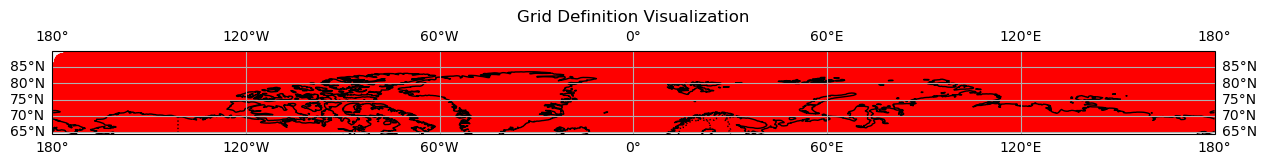

In [213]:
import pyresample as pr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assuming you already have target_def defined
# target_def = pr.geometry.GridDefinition(lons=target_lon, lats=target_lat)

def plot_grid_definition(grid_def):
    # Get the lons and lats from the grid definition
    lons = grid_def.lons
    lats = grid_def.lats

    # Create a new figure with a map projection
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree()) 
    #ax = plt.axes(projection=ccrs.PlateCarree())
    # ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(
    # central_longitude=0.0,
    # central_latitude=90.0
    #))

    # Add coastlines and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.add_feature(cfeature.OCEAN, alpha=0.1)

    # Plot the grid points
    plt.scatter(lons, lats, c='red', s=1, alpha=0.5, transform=ccrs.PlateCarree())

    # Set the map extent based on the grid boundaries
    lon_min, lon_max = np.nanmin(lons), np.nanmax(lons)
    lat_min, lat_max = np.nanmin(lats), np.nanmax(lats)
    #ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add gridlines
    ax.gridlines(draw_labels=True)

    plt.title('Grid Definition Visualization')
    plt.show()

# Visualize the grid
plot_grid_definition(target_def)

# Created/Modified files during execution:
# No files created - plot displayed directly

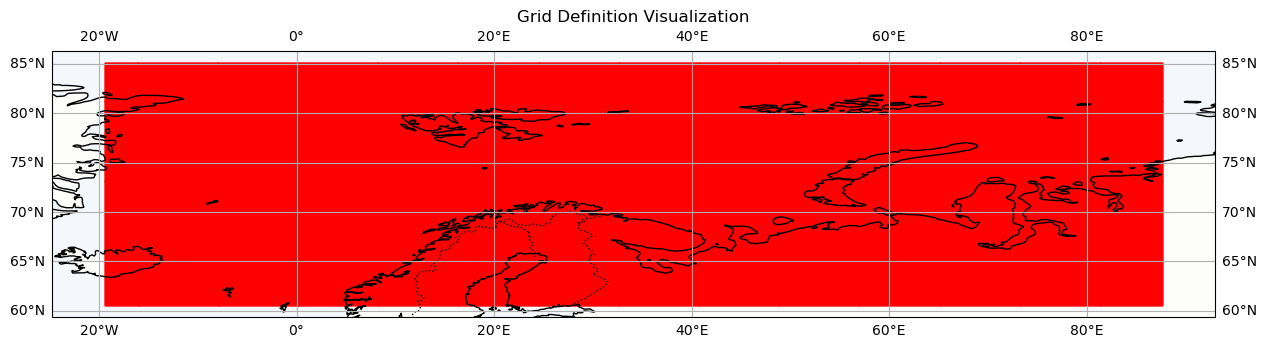

In [214]:
plot_grid_definition(src_def)


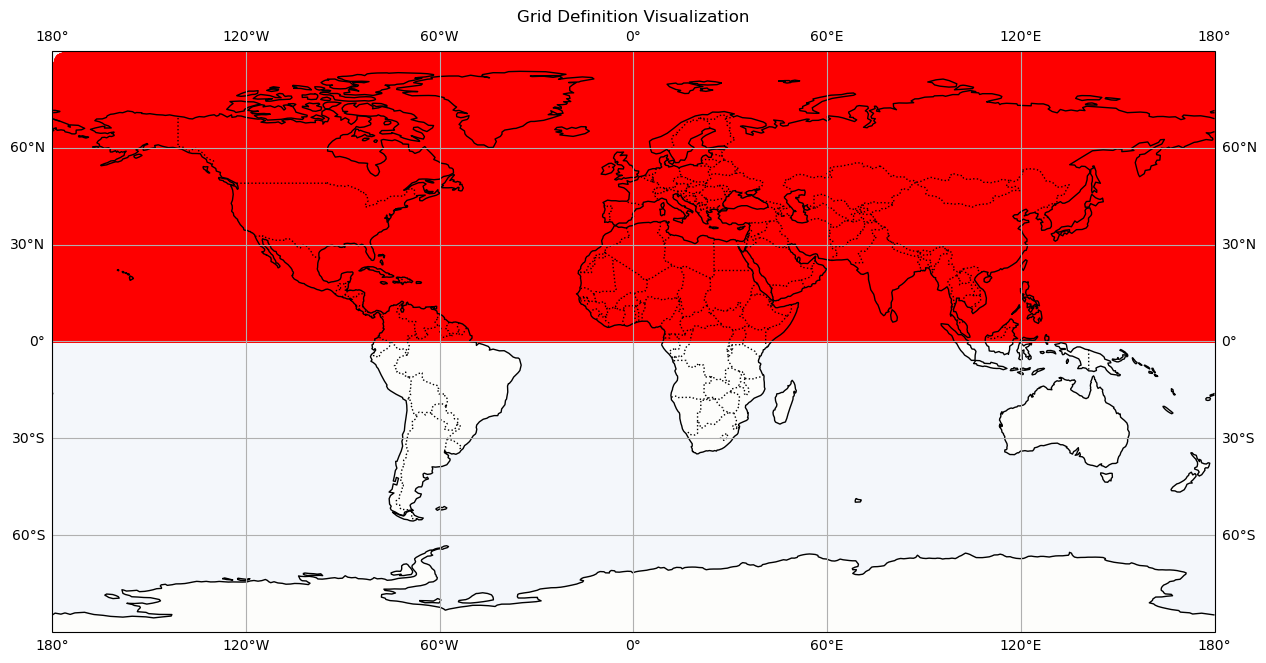

In [215]:
plot_grid_definition(orig_def)


In [84]:
def upsample_snowcover_carra_to_metgrid(
    input_file, output_file, harmonie_file, obs_var="prob_snow_c", var_out="prob_snow_c", model_var="fscov", prob_snow_thr=80.0
):
    # Open input datasets
    nc = xr.open_dataset(input_file)
    ds_harm = xr.open_dataset(harmonie_file)

    
    src_def,target_def, orig_def, target_lat, target_lon = get_geom_def(input_file, output_file, harmonie_file, obs_var, var_out, model_var, prob_snow_thr)

    # Resample data
    data_in = ds_harm[model_var].values
    bin_data_in = np.where((~np.isnan(data_in)) & (data_in > prob_snow_thr), 1, 0)
    times = ds_harm["time"].values
    # Using average resampling for downscaling
    data_out = pr.kd_tree.resample_nearest(
        src_def,
        #bin_data_in, #usig this I get a NaN error
        data_in,
        target_def,
        radius_of_influence=50000, #this is the default value!
        #sigmas=25000,
        fill_value=np.nan
    )
    #bin_data_out = pr.kd_tree.resample_nearest(
    #    src_def,
    #    bin_data_in,
    #    target_def,
    #   radius_of_influence=50000,
    #    #sigmas=25000, #only for gaussian type
    #    fill_value=np.nan
    #)
    # Process time values
    reference_date = np.datetime64("1978-01-01T00:00:00.0000")
    times = np.atleast_1d(times)
    seconds_since_1978 = [(t - reference_date) / np.timedelta64(1, "s") for t in times]
    std_unix_time = [seconds_to_unix_time(ts) for ts in seconds_since_1978]

    # Reshape data for output
    n_time = len(times)
    if len(data_out.shape) == 2:
        data_out = data_out.reshape(1, *data_out.shape)

    # Create binary snow cover data
    bin_data = np.where((~np.isnan(data_out)) & (data_out > prob_snow_thr), 1, 0)
    #print(bin_data.shape)
    #print(ds_harm["latitude"].shape)
    #print("harm shape")
    #print(ds_harm["longitude"].shape)
    #print(nc.lat.shape)
    ##print(ds_harm["latitude"].values)
    #print("target shape")
    #print(target_lat.shape)
    #print(data_out.shape)
    #unique_lats = np.sort(np.unique(target_lat))  
    #unique_lons = np.sort(np.unique(target_lon))
    #print(len(unique_lats))
    #unique_lons = 
        # Create output dataset
    ds = xr.Dataset(
        {
            var_out: (["time", "lat", "lon"], data_out),
            "bin_snow": (["time", "lat", "lon"], bin_data),
        },
        coords={
            "time": std_unix_time,
            "lat": target_lat,
            "lon": target_lon,
            #"lat": ds_harm["latitude"].values,
            #"lon": ds_harm["longitude"].values,
        },
    )


    return data_out, ds

In [85]:
data_out,ds = upsample_snowcover_carra_to_metgrid(
       input_file, output_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
    )

Borders of the harmonie grid
60.6 85.1
-19.399999999999977 87.6
{'lat_min': 60.6, 'lat_max': 85.1, 'lon_ranges': [(-19.399999999999977, 87.6)]}
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Borders of the resulting mesh
60.62499999999999 85.07499999999999


In [86]:
def dump_to_nc(ds,output_file):
    
    # Set attributes
    ds.time.attrs.update(
        {
            "units": "seconds since 1970-01-01 00:00:00",
            "long_name": "reference time of product",
        }
    )
    ds.lon.attrs["units"] = "degrees_east"
    ds.lat.attrs["units"] = "degrees_north"
    ds[var_out].attrs["units"] = "None"
    ds["bin_snow"].attrs.update(
        {"units": "None", "coordinates": "lat lon", "grid_mapping": "longlat"}
    )

    # Set grid mapping attributes
    # Set attributes
    ds.time.attrs.update(
        {
            "units": "seconds since 1970-01-01 00:00:00",
            "long_name": "reference time of product",
        }
    )
    ds.lon.attrs["units"] = "degrees_east"
    ds.lat.attrs["units"] = "degrees_north"
    ds[var_out].attrs["units"] = "None"
    ds["bin_snow"].attrs.update(
        {"units": "None", "coordinates": "lat lon", "grid_mapping": "longlat",
         "proj4": "+proj=longlat +datum=WGS84"}
    )
    # Save to NetCDF
    ds.to_netcdf(output_file)

    # Add projection information
    with Dataset(output_file, "a", format="NETCDF4") as fid:
        proj_var = fid.createVariable("projection_regular_ll", "i4", ())
        proj_var.grid_mapping_name = "longlat"
        proj_var.false_northing = 0.0
        proj_var.earth_shape = "spherical"
        proj_var.proj4 = "+proj=longlat +datum=WGS84"

    # Set grid mapping attributes


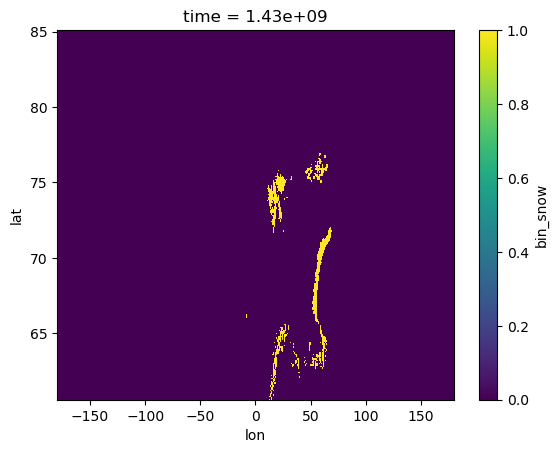

In [87]:
ds["bin_snow"].plot()

In [88]:
ds

<xarray.Dataset>
Dimensions:   (time: 1, lat: 490, lon: 7200)
Coordinates:
  * time      (time) float64 1.43e+09
  * lat       (lat) float64 85.07 85.02 84.97 84.92 ... 60.77 60.72 60.67 60.62
  * lon       (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    fscov     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    bin_snow  (time, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [89]:
# Sort latitude coordinates in ascending order  
sorted_lat = sorted(ds.lat.values)  

# Reindex the dataset with sorted latitude  
array_fixed = ds.reindex(lat=sorted_lat)  

# Alternatively, you can use sortby which is more concise  
array_fixed = ds.sortby('lat')  

In [90]:
ds.reindex(lat=sorted_lat)  

<xarray.Dataset>
Dimensions:   (time: 1, lat: 490, lon: 7200)
Coordinates:
  * time      (time) float64 1.43e+09
  * lat       (lat) float64 60.62 60.67 60.72 60.77 ... 84.92 84.97 85.02 85.07
  * lon       (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    fscov     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    bin_snow  (time, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [91]:
flip_lat = np.flip(ds.lat)  

In [92]:
flip_lat

<xarray.DataArray 'lat' (lat: 490)>
array([60.625, 60.675, 60.725, ..., 84.975, 85.025, 85.075])
Coordinates:
  * lat      (lat) float64 60.62 60.67 60.72 60.77 ... 84.92 84.97 85.02 85.07

In [93]:
dump_to_nc(ds,"snow_cover_from_carra_upsampled_to_met_grid.nc")

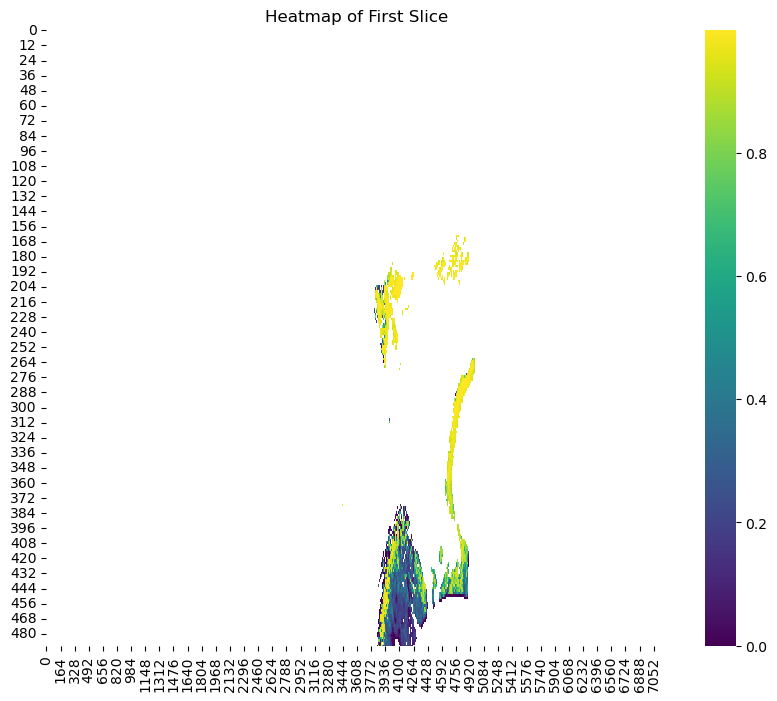

In [94]:
# Heatmap of first slice
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(data_out[0], cmap='viridis', mask=np.isnan(data_out[0]))
plt.title('Heatmap of First Slice')
plt.show()

# Method 2: 2D line plot of first row
#plt.figure(figsize=(10, 6))
#plt.plot(data_out[0, 0, :], 'b-', label='First row')
#plt.title('Line Plot of First Row')
#plt.xlabel('Index')
#plt.ylabel('Value')
#plt.legend()
#plt.show()


In [95]:
# original data set
ds_harm = xr.open_dataset(harmonie_file)

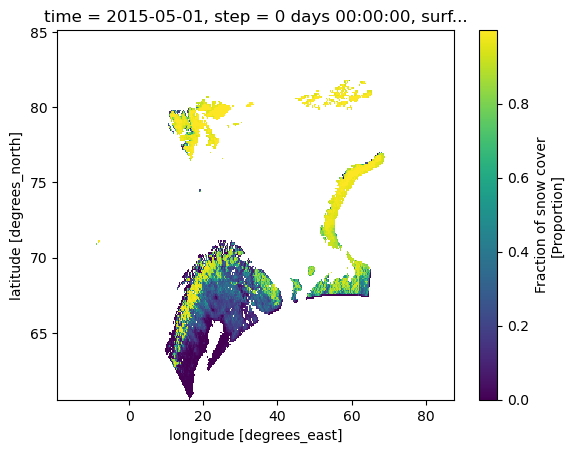

In [96]:
ds_harm["fscov"].plot()

In [97]:
ds_harm["longitude"].min()

<xarray.DataArray 'longitude' ()>
array(-19.4)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

In [98]:
ds_harm["longitude"].max()

<xarray.DataArray 'longitude' ()>
array(87.6)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

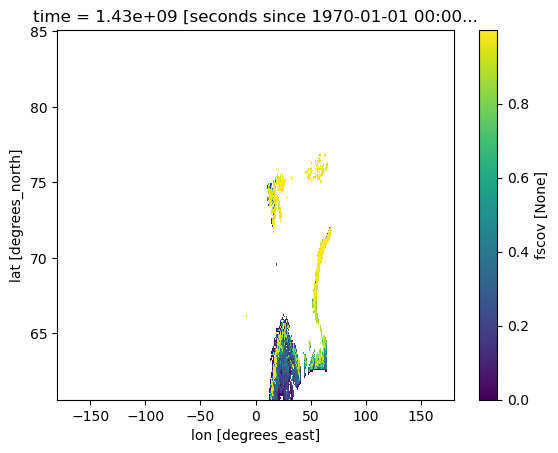

In [99]:
ds["fscov"].plot()

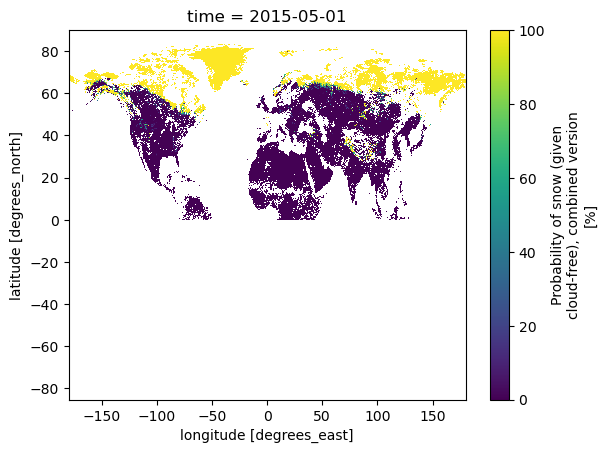

In [100]:
nc["prob_snow_c"].plot()

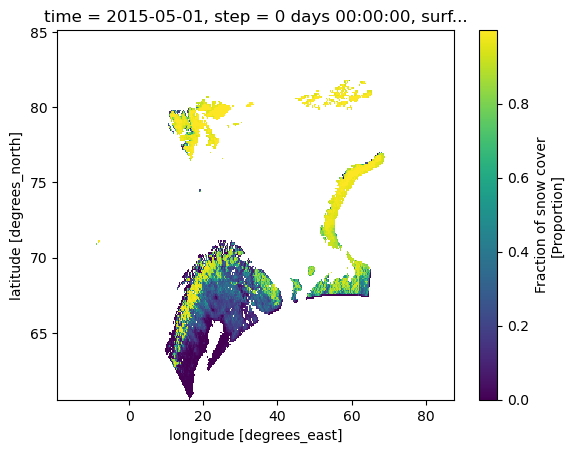

In [101]:
ds_harm["fscov"].plot()

In [397]:
nc["lat"].max()

<xarray.DataArray 'lat' ()>
array(9.96921e+36, dtype=float32)

In [416]:
nc.lat.min().values.item()

0.02483050897717476